# Creating a preprocessing function

In [1]:
#We started with reshaping the token_pro function from lecture 11 to
def preprocessing(corpus):
    """ (same as above, but: ) takes a list of strings (corpus of documents), 
    do preprocessing on each one, return list of preprocessed corpus
    """
    
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    stopwords = stopwords.words('english')
    corpusTokens = [word_tokenize(item) for item in corpus]
    corpusTokens = [ [word.lower().strip() for word in item if word.isalnum() and word not in stopwords] 
               for item in corpusTokens]
    
    return corpusTokens

# Importing data

In [2]:
import pandas as pd
#this is the file uploaded on canvas under exercise 11
newsItems = pd.read_csv('2021-10-18 News items on space.csv')
newsItems.head()

,string,date,url,author,source
0,William Shatner becomes the oldest person to r...,2021-10-13T14:54:44Z,https://www.engadget.com/william-shatner-blue-...,Jon Fingas,"{'id': 'engadget', 'name': 'Engadget'}"
1,Jett: The Far Shore Imagines Conscientious Spa...,2021-10-13T12:00:00Z,https://www.wired.com/story/jett-the-far-shore...,Lewis Gordon,"{'id': 'wired', 'name': 'Wired'}"
2,11 Scary Space Facts That'll Make You Apprecia...,2021-10-08T12:00:00Z,https://lifehacker.com/11-scary-space-facts-th...,Stephen Johnson,"{'id': None, 'name': 'Lifehacker.com'}"
3,UK takes on Elon Musk in the broadband space r...,2021-10-10T14:01:00Z,https://techncruncher.blogspot.com/2021/10/uk-...,noreply@blogger.com (Unknown),"{'id': None, 'name': 'Blogspot.com'}"
4,Blue Origin postpones William Shatner’s space ...,2021-10-10T19:12:00Z,https://techncruncher.blogspot.com/2021/10/blu...,noreply@blogger.com (Unknown),"{'id': None, 'name': 'Blogspot.com'}"


In [3]:
#using the function to preprocess strings and create lists of words for each document
corpusTokens = preprocessing(newsItems['string'])

In [4]:
#Obtain the average document length (after preprocessing has removed stopwords)
length_docs = [len(document) for document in corpusTokens]
averageWordCount = sum(length_docs)/len(newsItems.string)
averageWordCount

51.15

# Creating visualization of most frequent words

In [5]:
from collections import Counter
from datetime import datetime

In [6]:
begin_time = datetime.now()


iteration = 0
divide = 1 #variable to vary the fraction of the dataset that is computed, i.e. when testing code

itermax = len(corpusTokens)//divide #the maximum number of iterations, function of 'divide'

count_all = Counter(corpusTokens[0]) #creating a counter, counting for first document

for i in range(1, itermax):
    count_all.update(Counter(corpusTokens[i])) #updating counter object with counts from all other docs.
    iteration+=1

countAllWords = count_all #storing the total counts in a second container (counter object)


#creating a DataFrame of the counter's top 20 words, setting column names and index
count_all = pd.DataFrame(count_all.most_common(20)).rename(columns={0:'word',1:'count'}).set_index('word')


end_time = datetime.now()
print('time spent',end_time-begin_time)
count_all.head(5)

time spent 0:00:00.016000


,count
word,
space,62
shatner,21
william,19
chars,19
blue,17


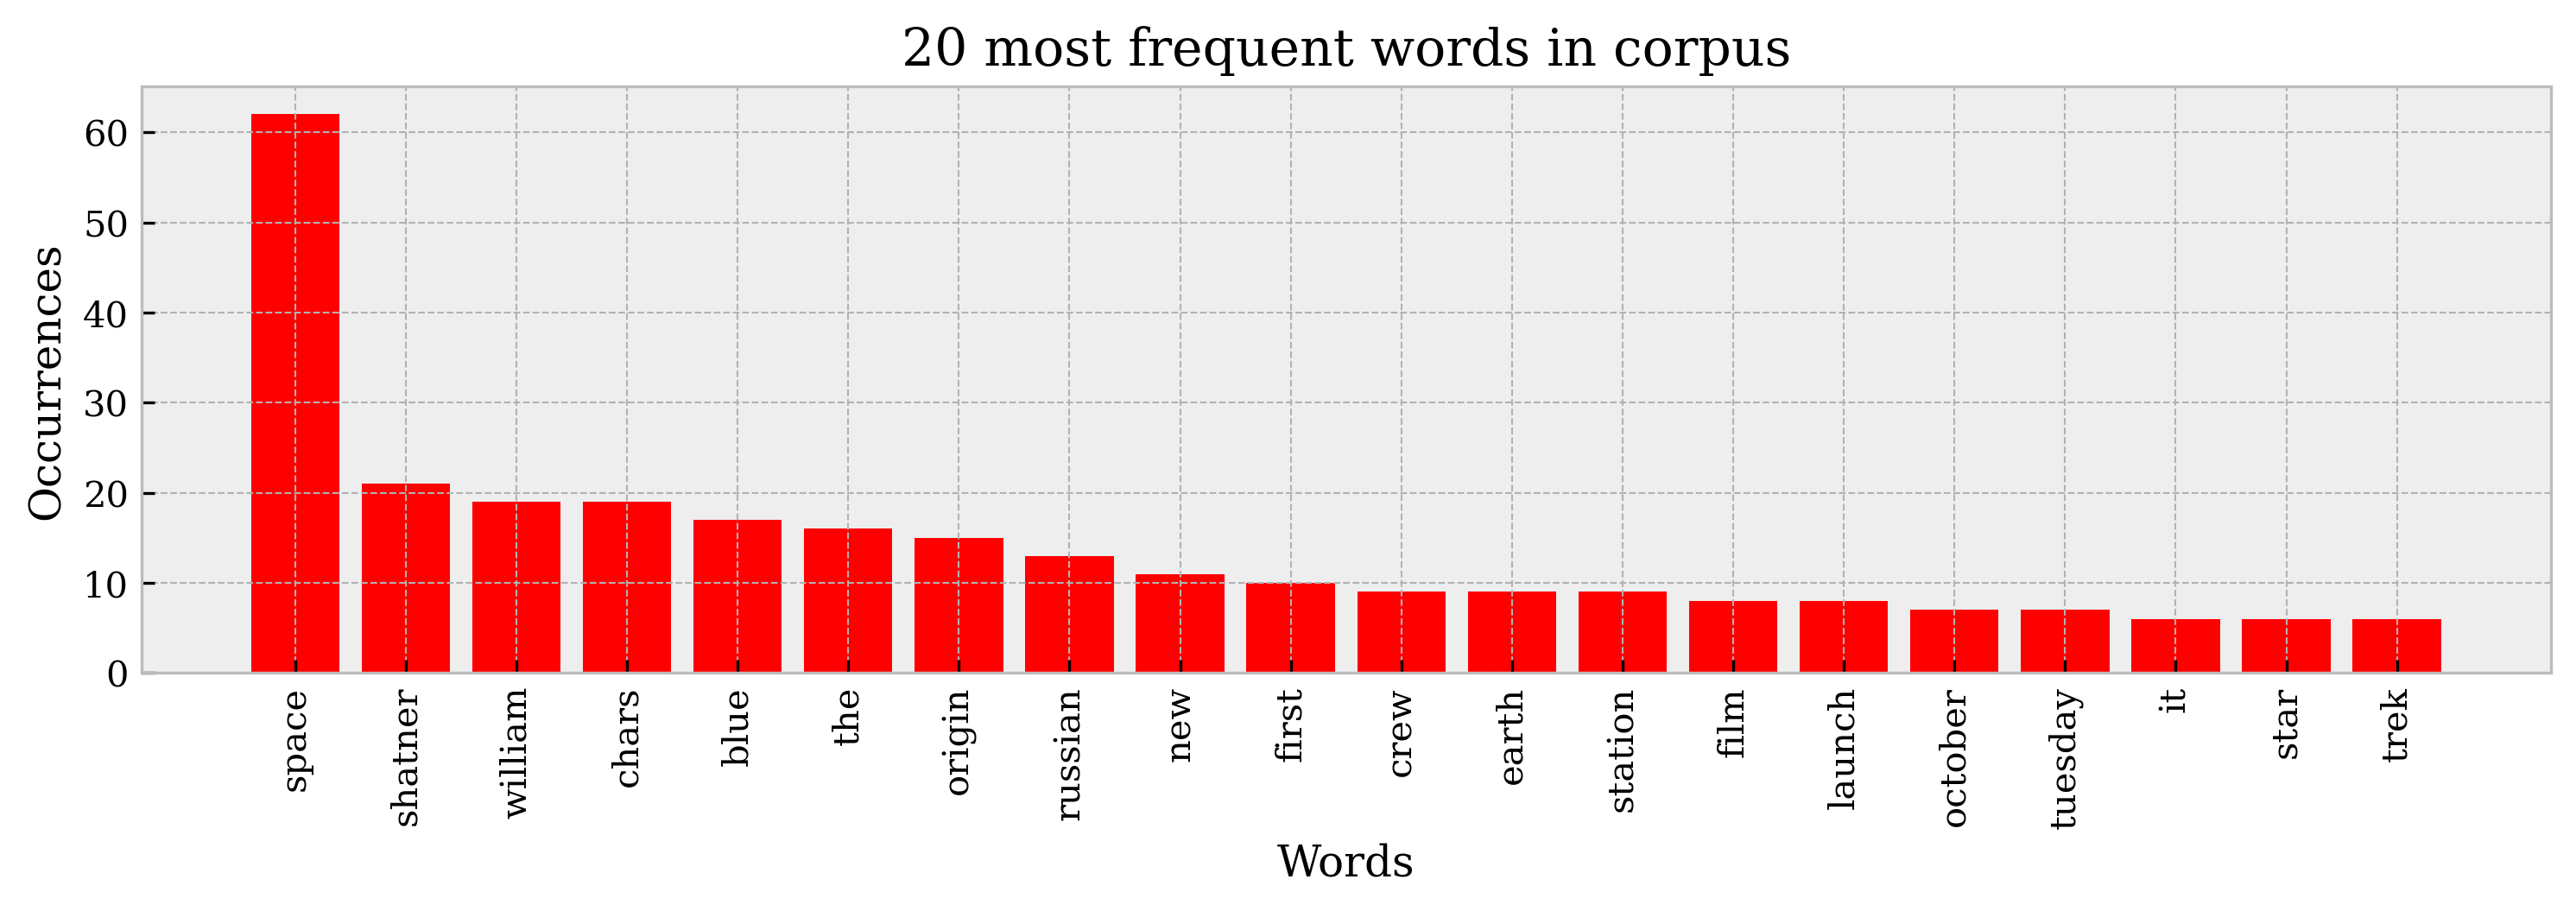

In [7]:
#barchart of the 20 most frequent words from the corpus, from above DataFrame
import matplotlib.pyplot as plt
import matplotlib.mathtext
plt.style.use('bmh')
plt.rcParams["font.family"] = "serif"

fig, most_common_words = plt.subplots(figsize=(12,3),dpi=300)

most_common_words.bar(count_all.index,count_all['count'],color='r')
most_common_words.set_xticks(count_all.index)
most_common_words.set_xticklabels(count_all.index, rotation='vertical')
most_common_words.set_ylabel('Occurrences')
most_common_words.set_xlabel('Words')
most_common_words.set_title("20 most frequent words in corpus")
plt.savefig('most_common_20.png')
plt.show()

# Towards a bag of words vector representation

In [8]:
#We can extract our vocabulary from the keys of the Counter object holding all words
vocabulary = list(countAllWords.keys())
vocabulary.sort() #sorting them alphabetically (0-9,a-z)
len(vocabulary) #checking total number of words in corpus after preprocessing

472

## Suggested task to think about or implement before next session:
Create vector representations (Bag of Words, numeric vectors, whole numbers) for the documents based on the vocabulary. A sample vocabulary and three sample documents and resulting vectors are shown below. But try to implement on a more realistic dataset, such as the one offered in this session.

(We will cover an implementation of this in the next session)

The following cell further elaborates on the task with a very rudimentary examples of what processing we want to achieve, without the code to implement it.

## explanatory cell illustrating what the above task is about:

In [9]:
import numpy as np
import scipy.sparse
#example of the abovementioned task on a not realistic dataset:

#these are the docs:
docs = [['a', 'c', 'd'], ['a','b'], ['a','a','b','d']]
#an this is the vocabulary:
voca = ['a','b','c','d']


#the above "docs" have these vector representations in the form of BoW
vectors = [[1, 0, 1, 1], [1, 1, 0, 0], [2, 1, 0, 1]]

#the list of lists rep can take other forms, more suitable for calculations:
vectorsArray = np.array(vectors) #numpy array
vectorsSparse = scipy.sparse.csr_matrix(vectors) #sparse array - only values not zero are stored
print('list of lists\n',vectors)
print('\nnumpy array\n',vectorsArray)
print('\nsparse array\n',vectorsSparse)

list of lists
 [[1, 0, 1, 1], [1, 1, 0, 0], [2, 1, 0, 1]]

numpy array
 [[1 0 1 1]
 [1 1 0 0]
 [2 1 0 1]]

sparse array
   (0, 0)	1
  (0, 2)	1
  (0, 3)	1
  (1, 0)	1
  (1, 1)	1
  (2, 0)	2
  (2, 1)	1
  (2, 3)	1


In [10]:
vectorsSparse.toarray()

array([[1, 0, 1, 1],
       [1, 1, 0, 0],
       [2, 1, 0, 1]], dtype=int32)

In [11]:
def countDoc(document):
    from collections import Counter
    counts = Counter(document)
    return counts

def createBoW(document, vocabulary):
    resultVector = []
    for word in vocabulary:
        if word in document:
            resultVector.append(countDoc(document)[word])
        else:
            resultVector.append(0)
    return resultVector

In [12]:
#print(
#    
##        scipy.sparse.csr_matrix(
#            createBoW(
#                corpusTokens[0],vocabulary
#                    )
#                )
#           )

bowMatrix = []
for document in corpusTokens:
    bowMatrix.append( createBoW(document, vocabulary))
scipy.sparse.csr_matrix(bowMatrix)

<20x472 sparse matrix of type '<class 'numpy.intc'>'
	with 666 stored elements in Compressed Sparse Row format>

$ tf(t,d) = \frac{count(t)}{len(d)} $

In [13]:
def countDoc(document):
    from collections import Counter
    counts = Counter(document)
    return counts

def createBoW_tf(document, vocabulary):
    resultVector = []
    for word in vocabulary:
        if word in document:
            resultVector.append(countDoc(document)[word] / len(document))
        else:
            resultVector.append(0)
    return resultVector

In [14]:
tfMatrix = []
for document in corpusTokens:
    tfMatrix.append( createBoW_tf(document, vocabulary))
print(np.round(scipy.sparse.csr_matrix(tfMatrix)[0],4))

  (0, 10)	0.0161
  (0, 13)	0.0323
  (0, 29)	0.0161
  (0, 50)	0.0323
  (0, 51)	0.0161
  (0, 58)	0.0323
  (0, 71)	0.0161
  (0, 94)	0.0323
  (0, 105)	0.0323
  (0, 151)	0.0161
  (0, 153)	0.0323
  (0, 157)	0.0323
  (0, 174)	0.0161
  (0, 186)	0.0323
  (0, 188)	0.0323
  (0, 204)	0.0323
  (0, 236)	0.0323
  (0, 240)	0.0161
  (0, 241)	0.0161
  (0, 264)	0.0323
  (0, 267)	0.048400000000000006
  (0, 269)	0.0323
  (0, 274)	0.0323
  (0, 282)	0.048400000000000006
  (0, 291)	0.0323
  (0, 311)	0.0161
  (0, 352)	0.048400000000000006
  (0, 366)	0.0323
  (0, 372)	0.048400000000000006
  (0, 377)	0.0323
  (0, 406)	0.0323
  (0, 423)	0.0323
  (0, 458)	0.048400000000000006


## Adding inverse document frequency to the scheme

$ idf(t,D) = \log{\frac{N_D}{|t \in d : d \in D|}} $

In [15]:
def corpusBoW(corpus):
    # taking a corpus, returning representations for all documents, in a matrix.
    
    from collections import Counter
    from math import log10
    from scipy.sparse import csr_matrix
    import numpy as np
    
    count_all = Counter(corpus[0]) #creating a counter, counting for first document
    for document in corpus[1:]:
        count_all.update(Counter(document)) #updating counter object with counts from all other docs.
    vocabulary = list(count_all.keys())
    vocabulary.sort()
    
    
    idfWeights = {}
    for word in vocabulary:
        presence = 0
        for document in corpus:
            if word in document:
                presence += 1
        idfWeights[word] = log10(len(corpus) / presence)
    
    
    def countDoc(document):
        from collections import Counter
        counts = Counter(document)
        return counts
    
    
    
    bowLists = list()
    for document in corpus:
        resultVector = []
        for word in vocabulary:
            #if word in document:
            resultVector.append(  (countDoc(document)[word]/len(document)) * idfWeights[word]  )
            #else:
            #    resultVector.append(0)
        bowLists.append(resultVector)
    
    bowMatrix = csr_matrix(bowLists)
    
    return bowMatrix

In [16]:
bowVectors = corpusBoW(corpusTokens)
print(bowVectors[0])

  (0, 10)	0.020984354768773892
  (0, 13)	0.041968709537547784
  (0, 29)	0.020984354768773892
  (0, 50)	0.041968709537547784
  (0, 51)	0.016129032258064516
  (0, 58)	0.01686705629936573
  (0, 71)	0.00035929668888955174
  (0, 94)	0.019421290042837495
  (0, 105)	0.026577701320784474
  (0, 151)	0.020984354768773892
  (0, 153)	0.026577701320784474
  (0, 157)	0.041968709537547784
  (0, 174)	0.016129032258064516
  (0, 186)	0.041968709537547784
  (0, 188)	0.041968709537547784
  (0, 204)	0.022547419494710286
  (0, 236)	0.041968709537547784
  (0, 240)	0.020984354768773892
  (0, 241)	0.013288850660392237
  (0, 264)	0.041968709537547784
  (0, 267)	0.06295306430632167
  (0, 269)	0.022547419494710286
  (0, 274)	0.01686705629936573
  (0, 282)	0.06295306430632167
  (0, 291)	0.041968709537547784
  (0, 311)	0.016129032258064516
  (0, 352)	0.022061223660470534
  (0, 366)	0.041968709537547784
  (0, 377)	0.022547419494710286
  (0, 406)	0.011186693104021171
  (0, 423)	0.022547419494710286
  (0, 458)	0.02206

In [17]:
pairwise_cosine = bowVectors * bowVectors.T
print(np.round(pairwise_cosine[0,:],4))

  (0, 0)	0.032
  (0, 1)	0.0004
  (0, 2)	0.0
  (0, 3)	0.0001
  (0, 4)	0.0029000000000000002
  (0, 5)	0.0029000000000000002
  (0, 6)	0.0027
  (0, 7)	0.0001
  (0, 8)	0.0026000000000000003
  (0, 9)	0.0
  (0, 10)	0.0014
  (0, 11)	0.0007
  (0, 12)	0.0001
  (0, 13)	0.0008
  (0, 14)	0.0005
  (0, 15)	0.0002
  (0, 16)	0.0031000000000000003
  (0, 17)	0.0034000000000000002
  (0, 18)	0.0006000000000000001
  (0, 19)	0.0007


In [18]:
corpusNonstop = [(" ").join([word for word in document]) for document in corpusTokens]
corpusNonstop[0]

'william shatner becomes oldest person reach space it official plenty hype slight delay william shatner become oldest person fly space the star trek icon one four crew members aboard blue origin mission flew altitude 66 miles he it official plenty hype slight delay william shatner become oldest person fly space the star trek icon one four crew members aboard blue origin chars'

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

v_tr = TfidfVectorizer(min_df=1)
tfidf = v_tr.fit_transform(corpusNonstop)

In [20]:
tfidf

<20x468 sparse matrix of type '<class 'numpy.float64'>'
	with 659 stored elements in Compressed Sparse Row format>

In [60]:
print(np.round(tfidf[0],3))

  (0, 8)	0.107
  (0, 10)	0.214
  (0, 26)	0.107
  (0, 47)	0.214
  (0, 48)	0.094
  (0, 55)	0.134
  (0, 68)	0.033
  (0, 91)	0.14400000000000002
  (0, 102)	0.17
  (0, 148)	0.107
  (0, 150)	0.17
  (0, 154)	0.214
  (0, 171)	0.094
  (0, 183)	0.214
  (0, 184)	0.214
  (0, 200)	0.155
  (0, 232)	0.214
  (0, 236)	0.107
  (0, 237)	0.085
  (0, 260)	0.214
  (0, 263)	0.321
  (0, 265)	0.155
  (0, 270)	0.134
  (0, 278)	0.321
  (0, 287)	0.214
  (0, 307)	0.094
  (0, 348)	0.188
  (0, 362)	0.214
  (0, 368)	0.096
  (0, 373)	0.155
  (0, 402)	0.111
  (0, 419)	0.155
  (0, 454)	0.188


In [61]:
cosinePairwise_tfidf = tfidf*tfidf.T
print(cosinePairwise_tfidf[0])

  (0, 18)	0.0407149697272976
  (0, 19)	0.047183454202539374
  (0, 17)	0.209373636545811
  (0, 16)	0.22681435133429223
  (0, 15)	0.032295330698665206
  (0, 14)	0.02692909148257592
  (0, 13)	0.05981051344535105
  (0, 12)	0.03297306044955289
  (0, 11)	0.0423354981798926
  (0, 10)	0.0780886165482238
  (0, 9)	0.007300202353936351
  (0, 8)	0.13695292243467944
  (0, 7)	0.030763616029847916
  (0, 6)	0.16034992067953227
  (0, 5)	0.18208523312435188
  (0, 4)	0.2005499142687179
  (0, 3)	0.01080737641687126
  (0, 2)	0.013329778908330868
  (0, 1)	0.026881912402825
  (0, 0)	1.0


In [63]:
top5sklearn = list(np.argsort(cosinePairwise_tfidf.toarray()[0])[-5:])
top5sklearn.reverse()
top5sklearn = dict(zip(top5sklearn,[cosinePairwise_tfidf[0,i] for i in top5sklearn]))
top5sklearn = pd.DataFrame(top5sklearn,index=['item']).T
top5sklearn
#of course this makes most sense. the two equal texts are equal (0 and 0)

,item
0,1.000000
16,0.226814
17,0.209374
4,0.200550
5,0.182085


In [65]:
top5manual = list(np.argsort(pairwise_cosine.toarray()[0])[-5:])
top5manual.reverse()
top5manual = dict(zip(top5manual,[pairwise_cosine[0,i] for i in top5manual]))
top5manual = pd.DataFrame(top5manual,index=['item']).T
top5manual

,item
0,0.031988
17,0.003420
16,0.003071
4,0.002930
5,0.002860


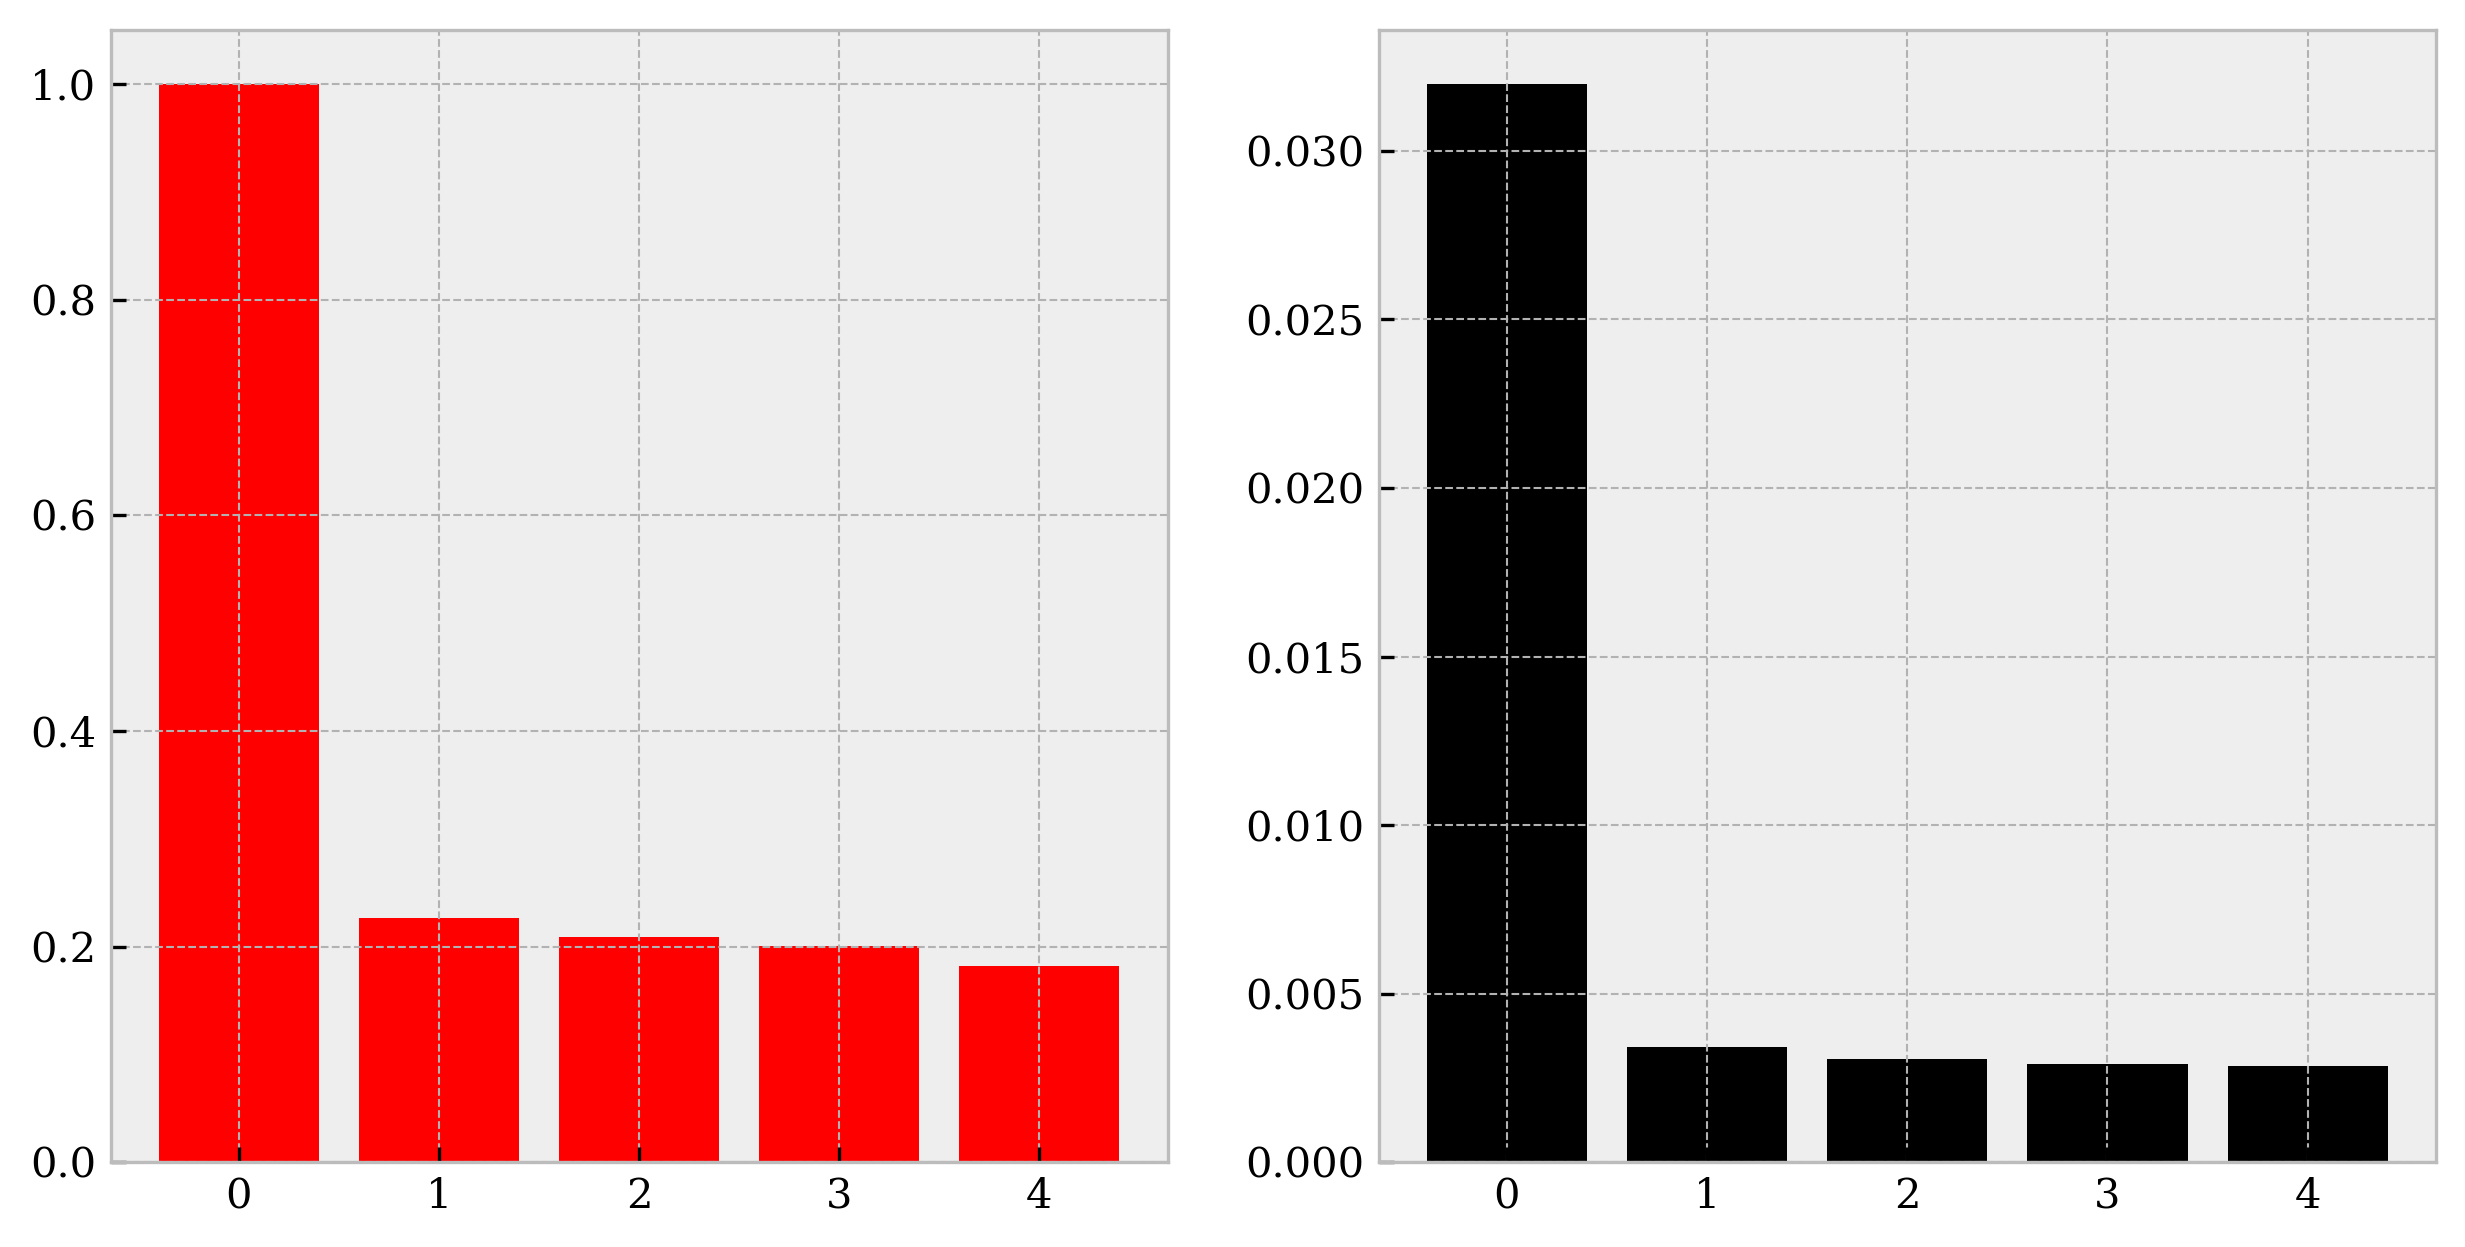

In [66]:
plt.style.use('bmh')
fig, (comparison1,comparison2) = plt.subplots(1,2,figsize=(10,5),dpi=300)

comparison1.bar(range(top5sklearn.shape[0]),top5sklearn.item,color='r')
comparison2.bar(range(top5manual.shape[0]),top5manual.item,color='k')

plt.show()